In [57]:
import pandas as pd
import numpy as np
import random
import re

from collections import Counter
from pathlib import Path

from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path

sns.set_theme('notebook')

In [2]:
import spacy
from spacy.language import Language
from spacy.matcher import Matcher
from spacy.tokens import Doc, Span, Token
from spacy import displacy

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gilia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\gilia\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
fakenews_filepath_fulltext = Path('..', 'data', 'Fake.br-Corpus-master', 'full_texts')
assert fakenews_filepath_fulltext.exists(), 'Full texts folder not found!'

data = list()
for label_folder in ['fake', 'true']:
    subfolder = fakenews_filepath_fulltext / label_folder
    for file in subfolder.glob('*.txt'):
        data.append({
            'label' : label_folder,
            'content' : file.read_text(encoding='utf-8')
        })

random.shuffle(data)

label2code = {'fake' : 1, 'true' : 0}

df_news_fulltext = pd.DataFrame(data)

df_news_fulltext['content'] = df_news_fulltext['content'].str.lower()
df_news_fulltext['label_code'] = df_news_fulltext['label'].apply(label2code.get)

df_news_fulltext.info()
df_news_fulltext.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       7200 non-null   object
 1   content     7200 non-null   object
 2   label_code  7200 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 168.9+ KB


label                                            content  label_code
0  true   por felipe massao invariavelmente, uma das pr...           0
1  true   o novo diretor geral da polícia federal, fern...           0
2  true  ícone do feminismo, gloria steinem fala sobre ...           0
3  fake  "clodovil foi assassinado porque queria diminu...           1
4  fake  em agosto de 2016, teori alertava: "é o fim do...           1

In [5]:
# df = df_news
df = df_news_fulltext

In [6]:
psylin = pd.read_csv(
    Path('..', 'data', 'psycholinguistic_ properties', 'BP.csv'),
    sep=',',
    header=0,
    names=[
        'word',
        'grammatical_category',
        'concreteness',
        'subjectivity',
        'imagery',
        'aoa',
        'log_frequency',
        'frequency'
    ]
)

psylin.set_index('word', inplace=True)

vocabulary = psylin.to_dict(orient='index')

psylin.info()
psylin.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26874 entries, abafado to zurzir
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   grammatical_category  26874 non-null  object 
 1   concreteness          26874 non-null  float64
 2   subjectivity          26874 non-null  float64
 3   imagery               26874 non-null  float64
 4   aoa                   26874 non-null  float64
 5   log_frequency         26874 non-null  float64
 6   frequency             26874 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.6+ MB


grammatical_category  concreteness  subjectivity  imagery   aoa  \
word                                                                         
abafado                       a          3.47          3.92     3.96  5.28   
abafador                      a          5.73          2.84     5.10  7.25   
abalado                       a          2.61          4.12     3.59  7.62   
abalizado                     a          3.88          2.58     3.56  7.59   
abandonado                    a          3.68          4.16     3.97  5.24   

            log_frequency  frequency  
word                                  
abafado              7.11     1220.0  
abafador             4.41       82.0  
abalado              8.15     3450.0  
abalizado            4.36       78.0  
abandonado           9.75    17183.0

In [7]:
vocabulary['abafado']

{'grammatical_category': 'a',
 'concreteness': 3.47,
 'subjectivity': 3.92,
 'imagery': 3.96,
 'aoa': 5.28,
 'log_frequency': 7.11,
 'frequency': 1220.0}

In [8]:
def get_psychometric_stat(doc, feature):

    values = [
        getattr(token._, feature)
        for token in doc
        if getattr(token._, feature) != 0
    ]

    if (not values) | (all(v == 0 for v in values)):
        stats = {
            'mean' : 0.0,
            'median' : 0.0,
            'max' : 0.0,
            'min' : 0.0,
        }

    stats = {
        'mean' : np.round(np.mean(values), 4),
        'median' : np.round(np.median(values), 4),
        'std' : np.round(np.std(values, ddof=1), 3),
        'max' : np.max(values),
        'min' : np.min(values),
        'sum' : np.round(np.sum(values), 3),
        'vardiff' : np.round( np.var(np.diff(values), ddof=1), 4),
        'cv': np.round(np.std(values, ddof=1) / np.mean(values), 4) if np.mean(values) != 0 else 0
    }

    return stats



In [9]:
features = [
    'concreteness',
    'subjectivity',
    'imagery',
    'aoa'
]

In [10]:
for feature in features:
    if Token.has_extension(feature):
        Token.remove_extension(feature)
    Token.set_extension(feature, default=0)

    if Doc.has_extension(feature):
        Doc.remove_extension(feature)
    Doc.set_extension(feature, getter=lambda doc, f=feature: get_psychometric_stat(doc, f))

for feature in features:
    assert Token.has_extension(feature)
    assert Doc.has_extension(feature)
    print(feature)

if not Doc.has_extension('label'):
    print('Definindo propriedade: label')
    Doc.set_extension( 'label', default=None )

if not Doc.has_extension('asserts'):
    Doc.set_extension('asserts', default=list())

concreteness
subjectivity
imagery
aoa
Definindo propriedade: label


In [11]:
@Language.component('annotate_psychometrics')
def annotate_psychometrics(doc):
    for token in doc:
        lower = token.text.lower()
        if lower in vocabulary:
            values = vocabulary[lower]
            token._.concreteness = values['concreteness']
            token._.subjectivity = values['subjectivity']
            token._.imagery = values['imagery']
            token._.aoa = values['aoa']

    return doc


In [12]:
nlp = spacy.blank('pt')

# nlp.add_pipe('sentencizer')
nlp.add_pipe('annotate_psychometrics')


print(nlp.pipe_names)

['annotate_psychometrics']


In [13]:
text = df.loc[2546, 'content']

doc = nlp(text)

print(doc._.concreteness)
print(doc._.subjectivity)
print(doc._.imagery)
print(doc._.aoa)

{'mean': np.float64(4.4973), 'median': np.float64(4.31), 'std': np.float64(0.804), 'max': np.float64(6.24), 'min': np.float64(2.98), 'sum': np.float64(202.38), 'vardiff': np.float64(1.2532), 'cv': np.float64(0.1788)}
{'mean': np.float64(4.722), 'median': np.float64(4.69), 'std': np.float64(0.628), 'max': np.float64(5.87), 'min': np.float64(3.16), 'sum': np.float64(212.49), 'vardiff': np.float64(0.7288), 'cv': np.float64(0.133)}
{'mean': np.float64(4.4924), 'median': np.float64(4.46), 'std': np.float64(0.65), 'max': np.float64(5.77), 'min': np.float64(2.94), 'sum': np.float64(202.16), 'vardiff': np.float64(0.7637), 'cv': np.float64(0.1448)}
{'mean': np.float64(4.5389), 'median': np.float64(4.74), 'std': np.float64(1.463), 'max': np.float64(7.36), 'min': np.float64(1.79), 'sum': np.float64(204.25), 'vardiff': np.float64(4.957), 'cv': np.float64(0.3223)}


In [14]:
pipe = nlp.pipe(df_news_fulltext['content'].values)

concreteness = list()
subjectivity = list()
imagery = list()
aoa = list()
count = 0
max_count = 3_000

for doc, label in zip(pipe, df_news_fulltext['label'].values):
    if count > max_count:
        break
    count += 1
    doc._.label = label
    concreteness.append(dict(label=label,**doc._.concreteness))
    subjectivity.append(dict(label=label,**doc._.subjectivity))
    imagery.append(dict(label=label,**doc._.imagery))
    aoa.append(dict(label=label,**doc._.aoa))

df_concreteness = pd.DataFrame(concreteness)
df_subjectivity = pd.DataFrame(subjectivity)
df_imagery = pd.DataFrame(imagery)
df_aoa = pd.DataFrame(aoa)

c:\Users\gilia\anaconda3\envs\nlp\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\gilia\anaconda3\envs\nlp\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
doc._.label

In [16]:
df_aoa.head()

label    mean  median    std   max   min      sum  vardiff      cv
0  true  4.2310   4.030  1.682  9.24  0.87  3071.70   5.6632  0.3974
1  true  4.4461   4.465  1.747  8.82  0.71  3236.77   5.5082  0.3929
2  true  3.8631   3.470  1.562  8.27  0.87  2213.53   4.7657  0.4044
3  fake  4.3850   4.155  1.216  6.39  2.70    96.47   3.5164  0.2772
4  fake  3.9739   3.670  1.692  7.84  1.67   202.67   5.3136  0.4257

In [17]:
def plot_boxplot(frame, title=''):
    fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True)
    axes = np.ravel(axes)

    columns = [
        'mean',
        'median',
        'std',
        'max',
        'min',
        'sum',
        'vardiff',
        'cv'
    ]

    for ax, col in zip(axes, columns):
        sns.boxplot(frame, x='label', y=col, hue='label', ax=ax)
        ax.set_title(col.capitalize())
        ax.set_ylabel(None)
        ax.set_xlabel(None)
    fig.suptitle(title.capitalize())
    # fig.supxlabel('Tipo da notícia')
    plt.tight_layout()

In [18]:
df_concreteness.head()

label    mean  median    std   max   min      sum  vardiff      cv
0  true  4.1214    4.05  0.690  6.66  2.13  2992.17   0.8241  0.1674
1  true  4.2411    4.25  0.671  6.69  2.46  3087.49   0.7671  0.1582
2  true  4.1628    4.05  0.715  6.83  2.52  2385.31   0.9308  0.1717
3  fake  4.3477    4.30  0.484  5.50  3.50    95.65   0.4147  0.1113
4  fake  4.5357    4.59  0.875  6.32  3.11   231.32   1.3532  0.1929

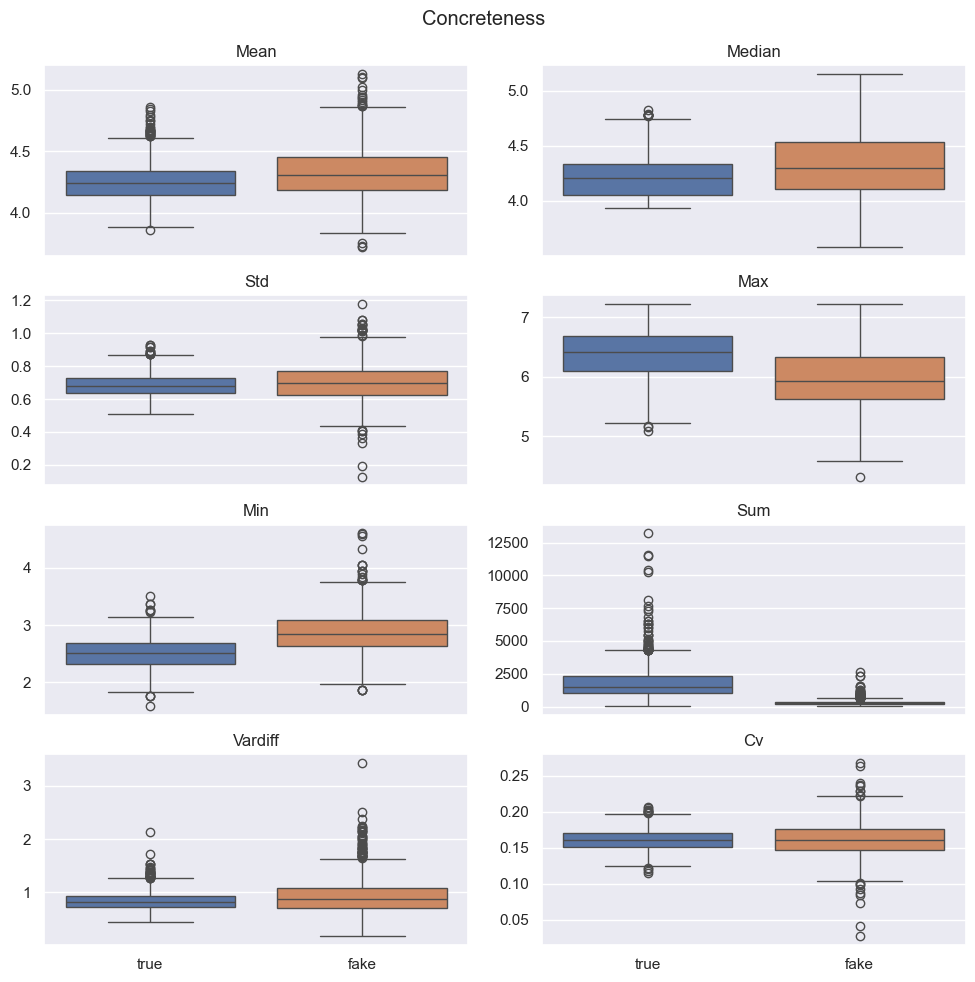

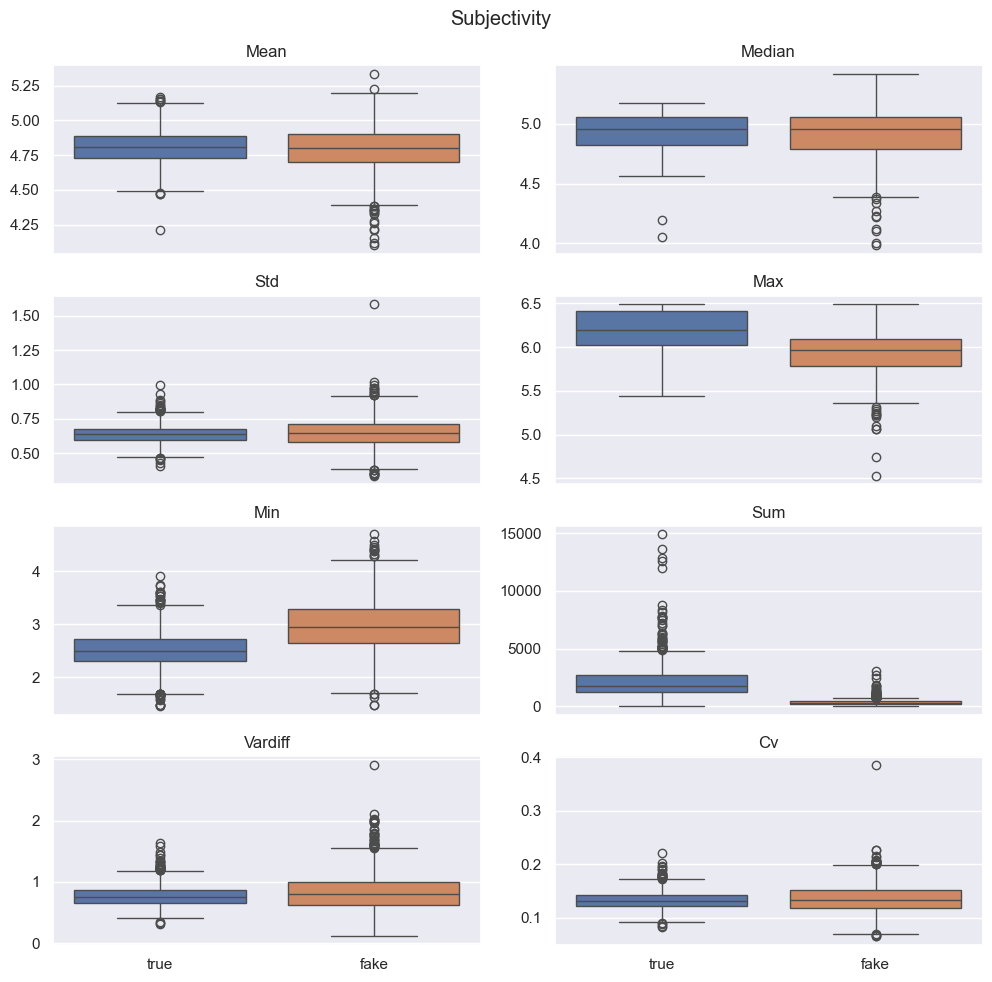

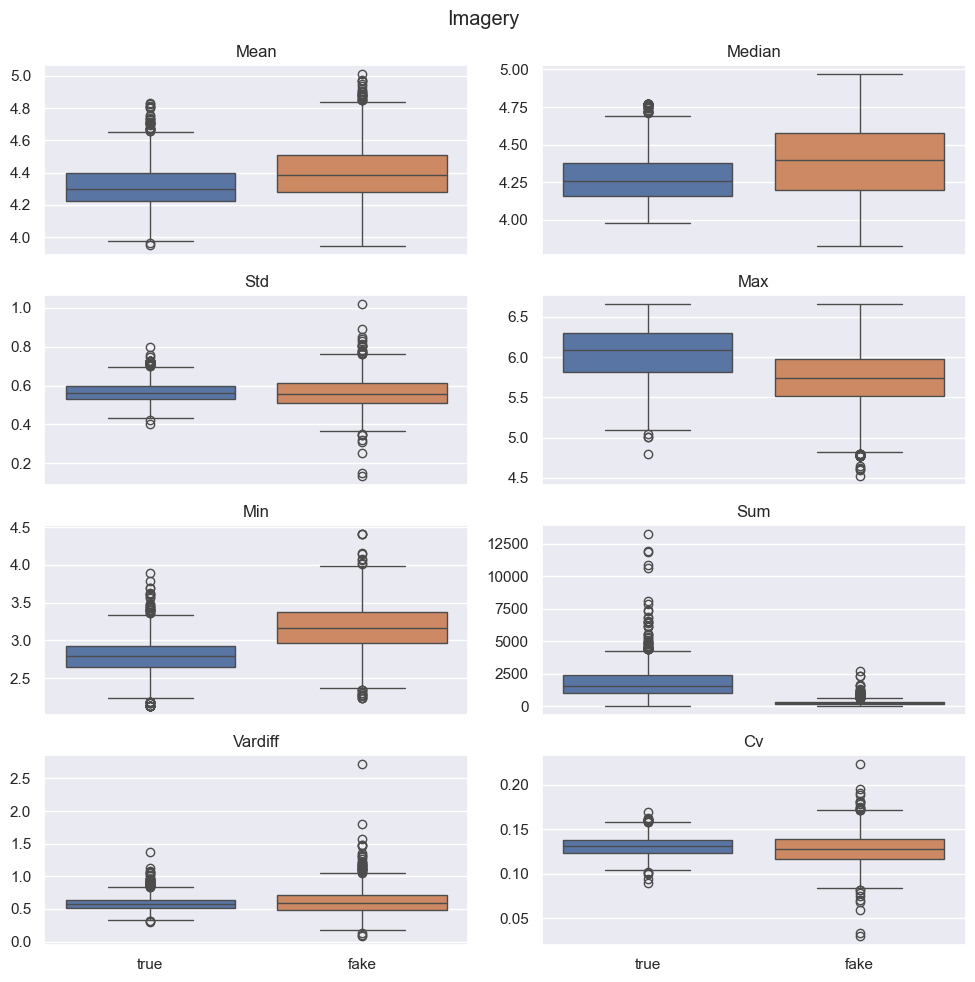

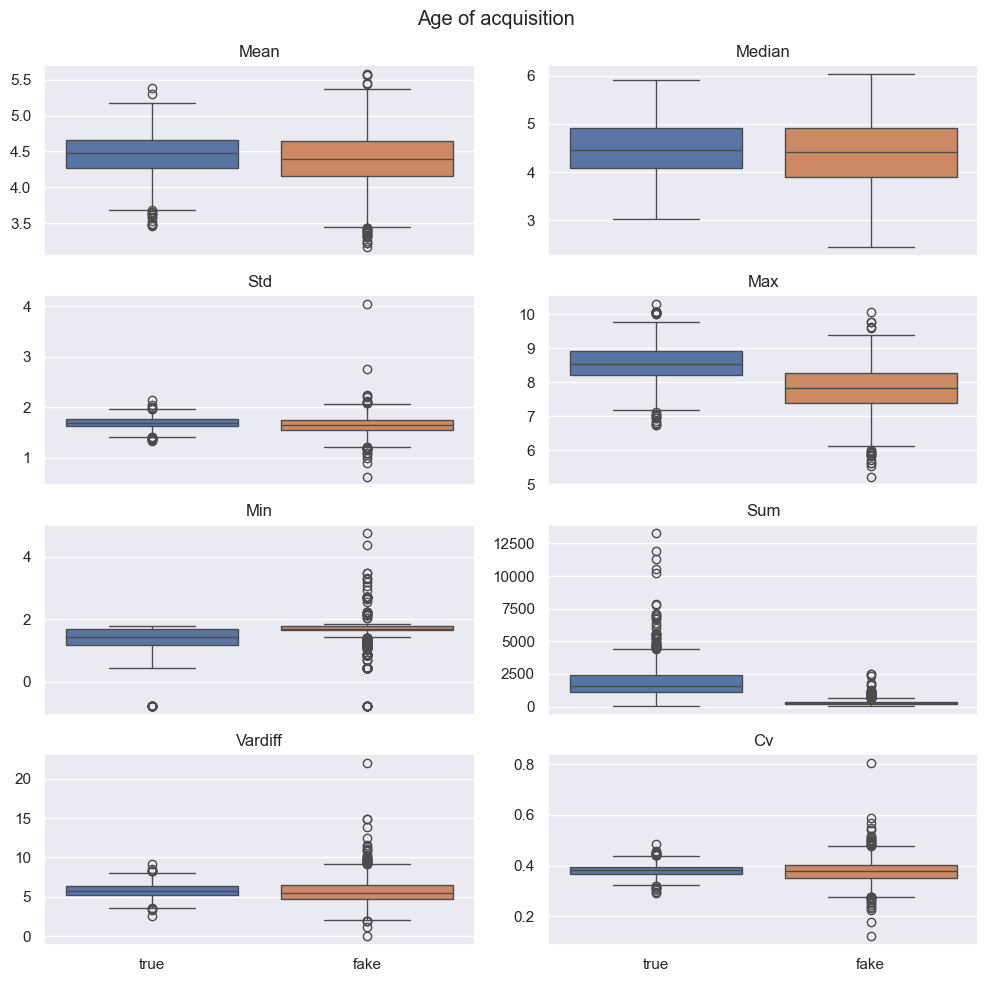

In [19]:
plot_boxplot(df_concreteness, 'Concreteness')
plot_boxplot(df_subjectivity, 'Subjectivity')
plot_boxplot(df_imagery, 'Imagery')
plot_boxplot(df_aoa, 'Age of Acquisition')

In [20]:
def plot_histogram(frame, title=''):
    fig, axes = plt.subplots(4, 2, figsize=(7, 10))
    axes = np.ravel(axes)

    columns = [
        'mean',
        'median',
        'std',
        'max',
        'min',
        'sum',
        'vardiff',
        'cv'
    ]

    for ax, col in zip(axes, columns):
        # sns.boxplot(frame, x='label', y=col, hue='label', ax=ax)
        sns.histplot(frame, x=col, hue='label', stat='percent', ax=ax)
        ax.set_title(col.capitalize())
        ax.set_ylabel(None)
        ax.set_xlabel(None)
    fig.suptitle(title.capitalize())
    # fig.supxlabel('Tipo da notícia')
    plt.tight_layout()


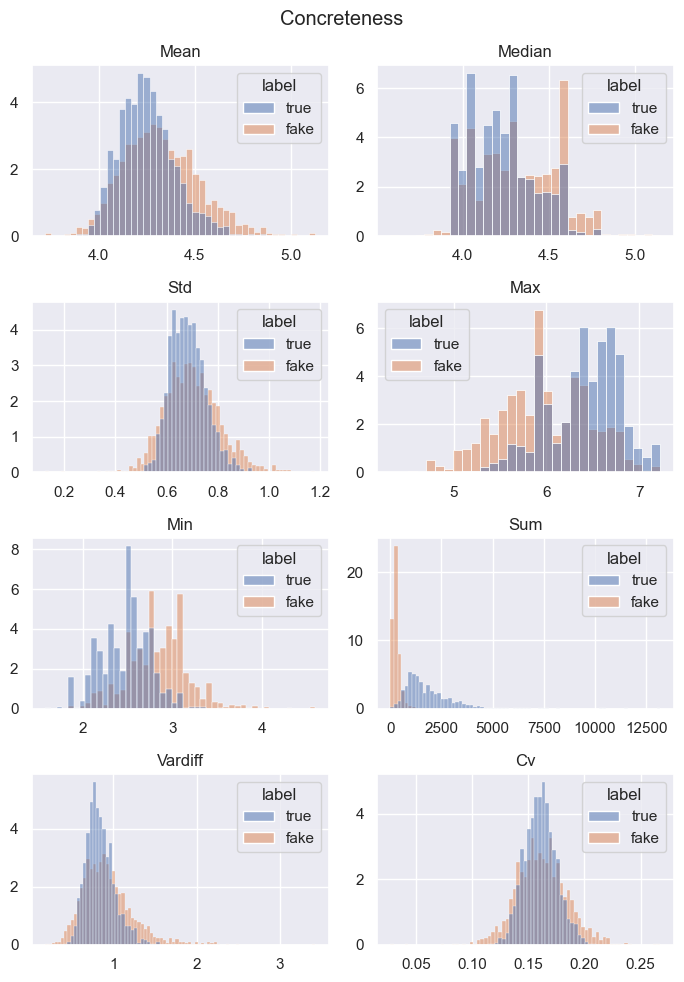

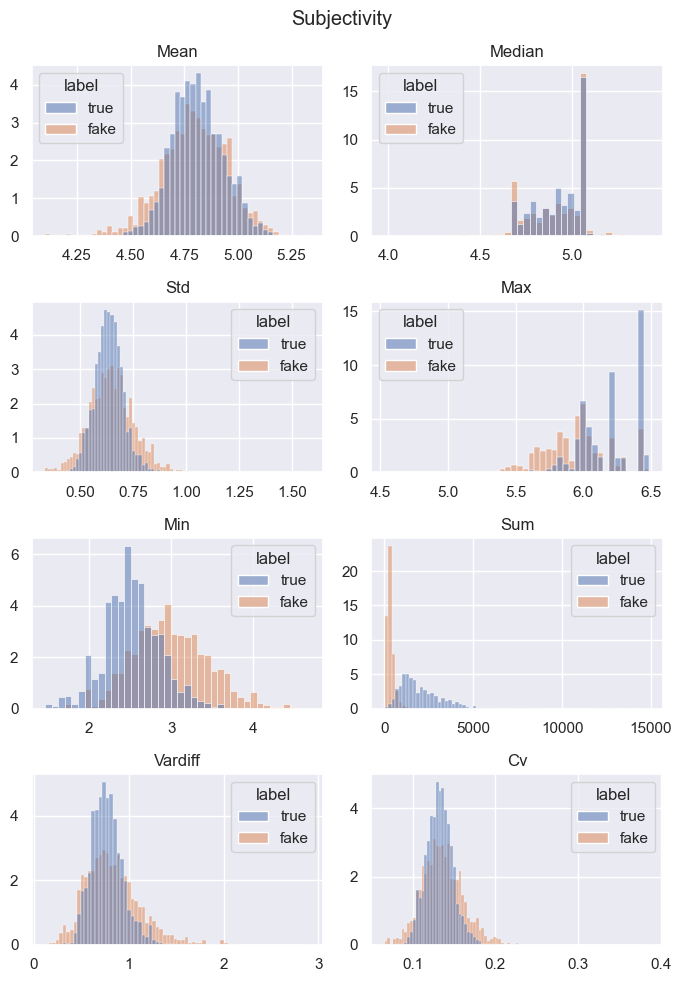

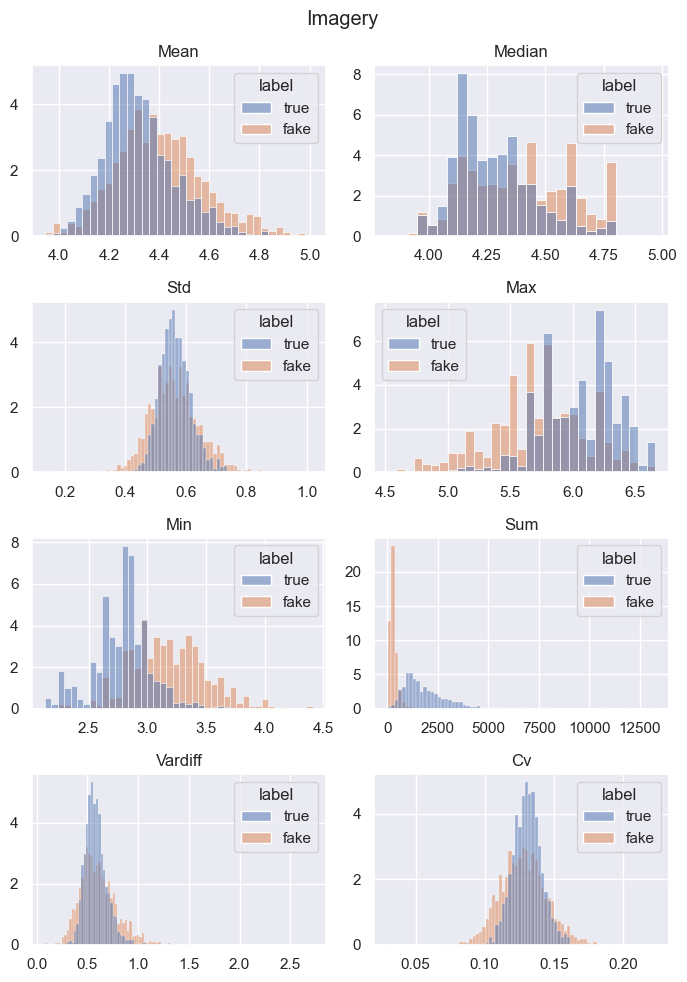

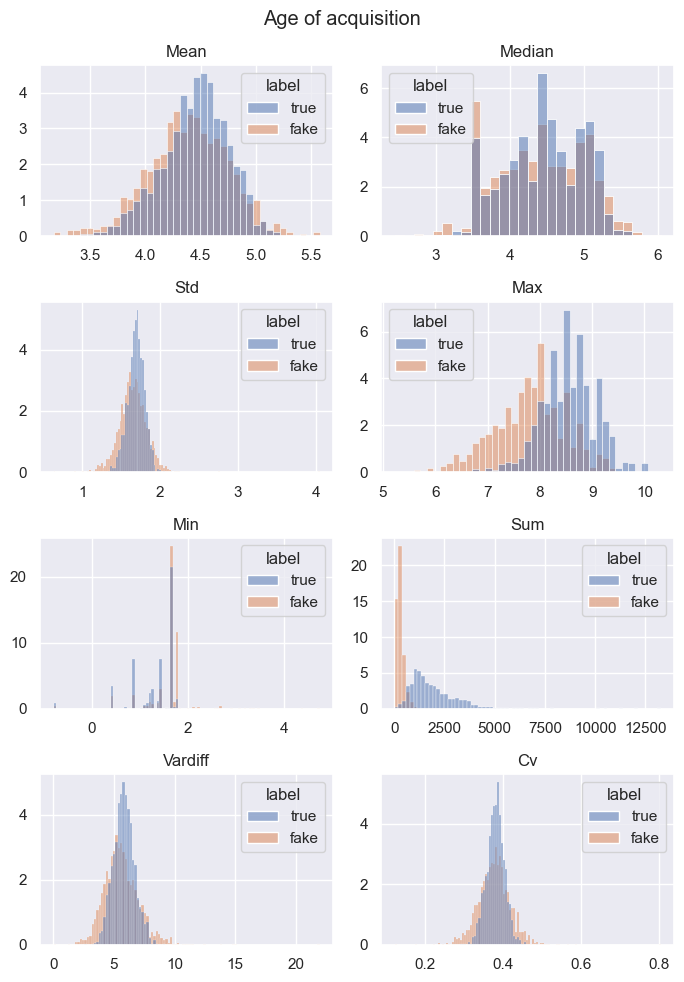

In [21]:
plot_histogram(df_concreteness, 'Concreteness')
plot_histogram(df_subjectivity, 'Subjectivity')
plot_histogram(df_imagery, 'Imagery')
plot_histogram(df_aoa, 'Age of Acquisition')

In [22]:
def pairplot(stat : str):
    df_stat = pd.DataFrame()

    df_stat['concreteness'] = df_concreteness[stat]
    df_stat['subjectivity'] = df_subjectivity[stat]
    df_stat['imagery'] = df_imagery[stat]
    df_stat['aoa'] = df_aoa[stat]

    df_stat['label'] = df_aoa['label']

    grid = sns.pairplot(df_stat, hue="label",
                 plot_kws=dict(alpha=0.5),
                 diag_kind="hist")
    return grid

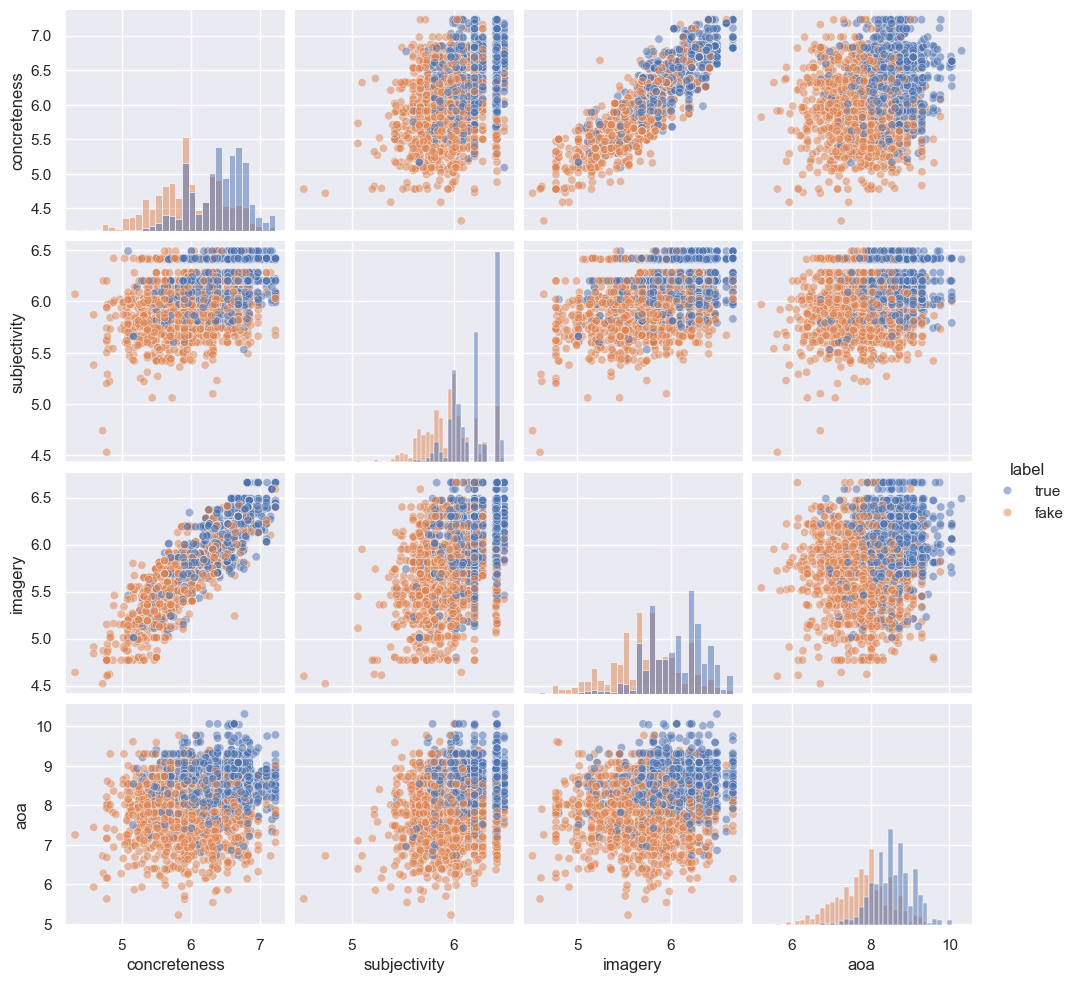

In [23]:
pairplot('max')

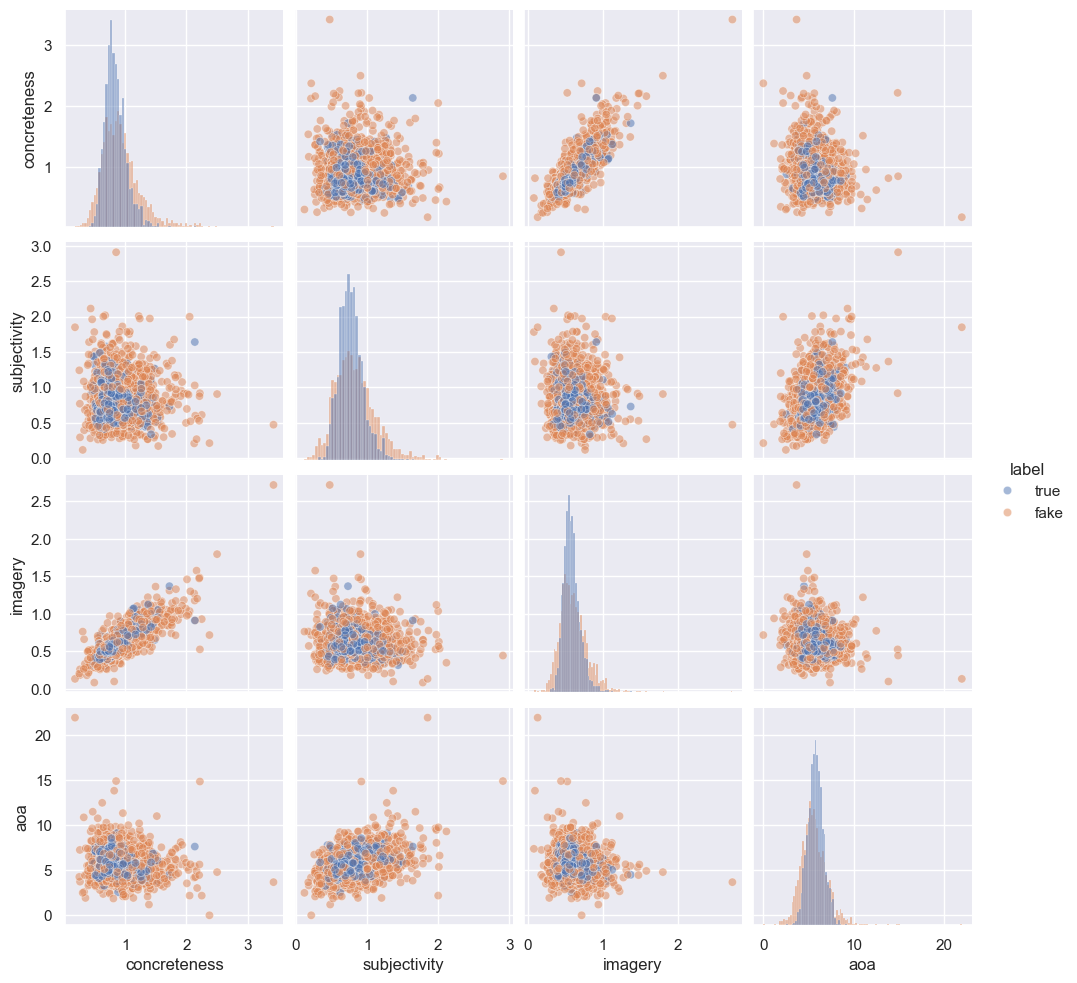

In [24]:
pairplot('vardiff')

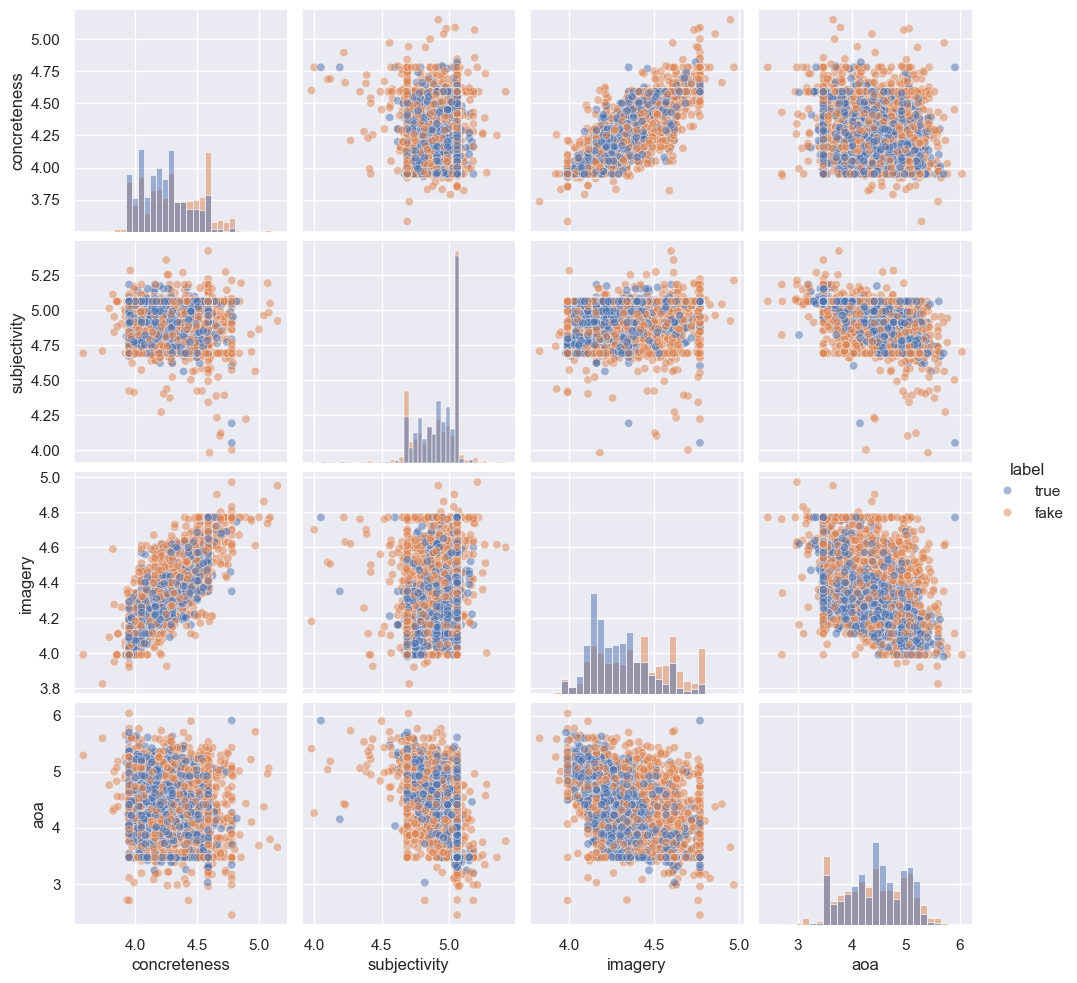

In [25]:
pairplot('median')

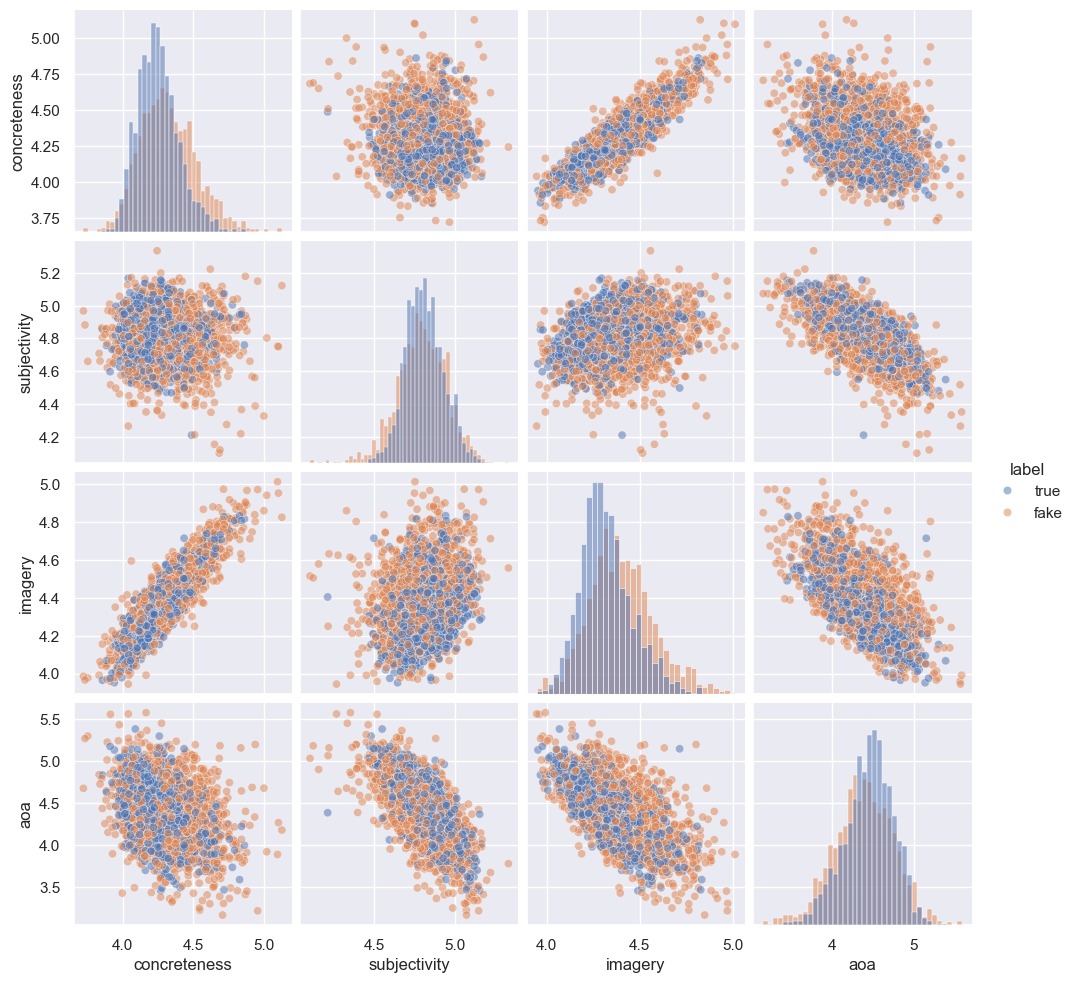

In [26]:
pairplot('mean')

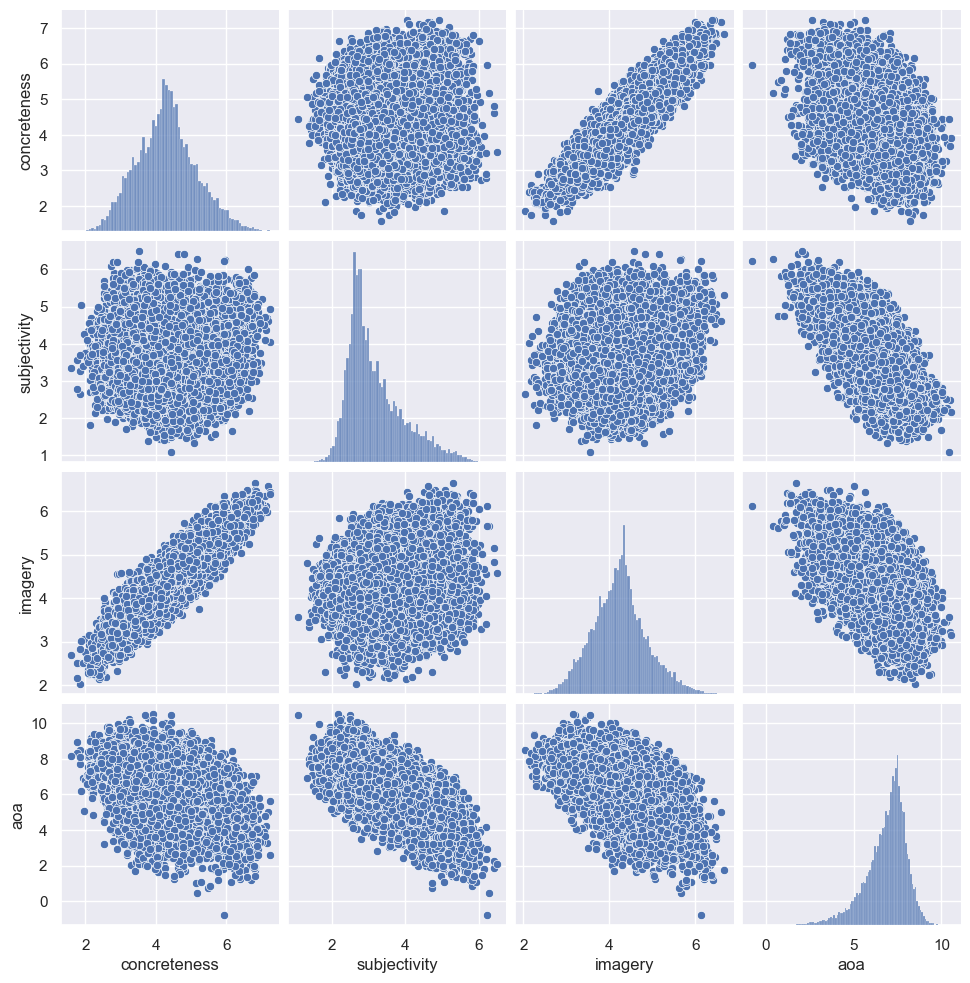

In [27]:
select = ['concreteness', 'subjectivity', 'imagery', 'aoa']
sns.pairplot(psylin[select], diag_kind="hist")

In [ ]:
class BasicRule:

    def apply(self, doc):
        raise NotImplementedError()

class Rule(BasicRule):

    def __init__(self, next_rule=None):
        self.next = next_rule

    def check(self, doc):
        stop = self.apply(doc)
        if not stop and self.next:
            self.next.check(doc)
        return doc


class BranchingRule(BasicRule):

    def __init__(self, if_true=None, if_false=False):
        self.branch_true = if_true
        self.branch_false = if_false

    def check(self, doc):
        if self.apply(doc):
            return self.branch_true.check(doc) if self.branch_true else doc
        else:
            return self.branch_false.check(doc) if self.branch_false else doc

In [30]:
class HighConcreteness(Rule):

    def __init__(self, threshold=6.0, next_rule=None):
        super().__init__(next_rule)
        self.threshold = threshold

    def apply(self, doc):
        if doc._.concreteness['max'] > self.threshold:
            doc._.asserts.append('true')
        else:
            doc._.asserts.append('fake')

        return False

class HighAgeOfAcquisition(Rule):

    def __init__(self, threshold=8.0, next_rule=None):
        super().__init__(next_rule)
        self.threshold = threshold

    def apply(self, doc):
        if doc._.concreteness['max'] > self.threshold:
            doc._.asserts.append('true')
        else:
            doc._.asserts.append('fake')

        return False

class HighImagery(Rule):

    def __init__(self, threshold=6.0, next_rule=None):
        super().__init__(next_rule)
        self.threshold = threshold

    def apply(self, doc):
        if doc._.concreteness['max'] > self.threshold:
            doc._.asserts.append('true')
        else:
            doc._.asserts.append('fake')

        return False

class HighSubjectivity(Rule):

    def __init__(self, threshold=6.0, next_rule=None):
        super().__init__(next_rule)
        self.threshold = threshold

    def apply(self, doc):
        if doc._.concreteness['max'] > self.threshold:
            doc._.asserts.append('true')
        else:
            doc._.asserts.append('fake')

        return False

In [31]:
# chain = HighAgeOfAcquisition(
#     next_rule=HighSubjectivity(
#         next_rule=HighConcreteness(
#             next_rule=HighImagery()
#         )
#     )
# )

chain = HighConcreteness(
    next_rule=HighSubjectivity(
        next_rule=HighAgeOfAcquisition(
            next_rule=HighImagery()
        )
    )
)

In [32]:
idx = 809
text = df_news_fulltext.loc[idx, 'content']

doc = nlp(text)

doc._.label = df_news_fulltext.loc[idx, 'label']

doc._.label

'fake'

In [33]:
doc._.asserts

[]

In [34]:
chain.check(doc)

saiba o que levou evaristo costa a pedir demissão da globo. evaristo costa é o jornalista brasileiro mais admirado nas redes sociais. mesmo com tanto sucesso ele surpreendeu a direção de jornalismo da globo com um pedido de demissão. ele ficará no ar até setembro e dará adeus a emissora que trabalhou por 19 anos.

o jornalista evaristo costa não vai renovar contrato com a globo, que vencerá daqui dois meses, segundo o colunista do uol flávio ricco. o colunista afirma que o apresentador do jornal hoje já comunicou a direção da emissora sobre a sua decisão, que seria motivada por questões pessoais. no entanto, especula-se que seu desinteresse seja pelo trabalho no jornalismo que além de ter menores salários que o segmento de entretenimento, impede que o jornalista fature fazendo publicidade. hoje o salário de evaristo costa é de r$ 70 mil. coo elemento comparativo podemos citar o salário de fátima bernardes, que no jornal nacional ganhava r$ 50 mil e hoje no comando do encontro fatura r$

In [ ]:
doc._.asserts

['fake', 'fake', 'fake', 'fake']

In [ ]:
def psycometric_classification(text : str, nlp=nlp, rule=chain):

    doc = nlp(text)
    chain.check(doc)
    counter = Counter(doc._.asserts)

    return 'fake' if (counter['fake'] > counter['true']) else 'true'

In [41]:
type(doc)

spacy.tokens.doc.Doc

In [43]:
isinstance(doc, Doc)

True

In [56]:
psycometric_classification(text)

'fake'

In [45]:
text

'saiba o que levou evaristo costa a pedir demissão da globo. evaristo costa é o jornalista brasileiro mais admirado nas redes sociais. mesmo com tanto sucesso ele surpreendeu a direção de jornalismo da globo com um pedido de demissão. ele ficará no ar até setembro e dará adeus a emissora que trabalhou por 19 anos.\n\no jornalista evaristo costa não vai renovar contrato com a globo, que vencerá daqui dois meses, segundo o colunista do uol flávio ricco. o colunista afirma que o apresentador do jornal hoje já comunicou a direção da emissora sobre a sua decisão, que seria motivada por questões pessoais. no entanto, especula-se que seu desinteresse seja pelo trabalho no jornalismo que além de ter menores salários que o segmento de entretenimento, impede que o jornalista fature fazendo publicidade. hoje o salário de evaristo costa é de r$ 70 mil. coo elemento comparativo podemos citar o salário de fátima bernardes, que no jornal nacional ganhava r$ 50 mil e hoje no comando do encontro fatura

In [ ]:
pipe = nlp.pipe(df_news_fulltext['content'].values)

count = 0
max_count = 3_000
predictions = list()
true_labels = list()

for doc, label in zip(pipe, df_news_fulltext['label'].values):
    count += 1
    if count > max_count: break

    chain.check(doc)
    counter = Counter(doc._.asserts)
    pred = 'fake' if counter['fake'] > counter['true'] else 'true'
    predictions.append(pred)
    true_labels.append(label)

In [ ]:
predictions = np.array(predictions).reshape(-1, 1)
true_labels = np.array(true_labels).reshape(-1, 1)

print(predictions.shape)
print(true_labels.shape)

print(classification_report(predictions, true_labels))

(3000, 1)
(3000, 1)
              precision    recall  f1-score   support

        fake       0.55      0.72      0.62      1120
        true       0.80      0.64      0.71      1880

    accuracy                           0.67      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.70      0.67      0.68      3000



Text(0.5, 1.0, 'Confusion Matrix')

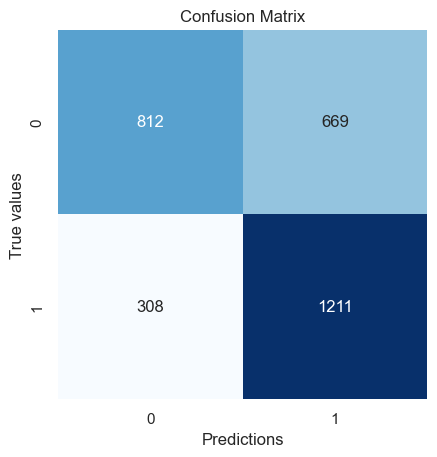

In [67]:
cmatrix = confusion_matrix(true_labels, predictions)

sns.heatmap(
    cmatrix,
    annot=True,
    linecolor='white', square=True, cmap='Blues',
    cbar=False, fmt='d'
)

plt.ylabel('True values')
plt.xlabel('Predictions')
plt.title('Confusion Matrix')